In [1]:
!pip install trino


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.5 MB/s eta 0:00:00


In [41]:
import trino
from trino.auth import BasicAuthentication

# Define connection parameters
trino_host = '18.188.112.55'
trino_port = 8080

# Define the function to query Trino and handle anomaly detection
def query_trino_for_anomalies():

# Connect to Trino
  conn = trino.dbapi.connect(
    host=trino_host,
    port=trino_port,
    user="admin",
)



In [34]:
import pandas as pd



# Define your date range
start_date = '2024-11-8'
end_date = '2024-11-11'

# Query logs and metrics data by date
query_logs = f"""
SELECT * FROM iceberg.apm_logs.logs
WHERE createdTime >= DATE '{start_date}'
AND createdTime < DATE '{end_date}'
"""

query_metrics = f"""
SELECT * FROM iceberg.apm_metrics.metrics
WHERE createdTime >= DATE '{start_date}'
AND createdTime < DATE '{end_date}'
"""

# Execute the queries and load the data into DataFrames
logs_df = pd.read_sql(query_logs, conn)
metrics_df = pd.read_sql(query_metrics, conn)

# Print the DataFrames
print(logs_df)
print(metrics_df)



<ipython-input-34-7e1c951d4d90>:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  logs_df = pd.read_sql(query_logs, conn)
<ipython-input-34-7e1c951d4d90>:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  metrics_df = pd.read_sql(query_metrics, conn)


   servicename language                                          scopename  \
0  order-srv-1     java          org.springdoc.api.AbstractOpenApiResource   
1  order-srv-1     java                 com.zaga.OrderProj.OrderController   
2  order-srv-1     java                 com.zaga.OrderProj.OrderController   
3  order-srv-1     java                 com.zaga.OrderProj.OrderController   
4  order-srv-1     java  org.apache.catalina.core.ContainerBase.[Tomcat...   
5  order-srv-1     java  org.springframework.web.servlet.mvc.support.De...   
6  order-srv-1     java  org.springframework.web.servlet.mvc.support.De...   
7  order-srv-1     java                    com.zaga.OrderProj.OrderService   
8  order-srv-1     java                    com.zaga.OrderProj.OrderService   

                            traceid            spanid         timeunixnano  \
0  14175767cb212204cbc967e20244473d  c1f0766d1ff870b8  1731039369136000000   
1  39e422b3980ca2d3b3a8144871b6cb6f  f7373e8660eb86ca  17310379

In [22]:
# Convert time columns to datetime format
logs_df['createdtime'] = pd.to_datetime(logs_df['createdtime'])
metrics_df['createdtime'] = pd.to_datetime(metrics_df['createdtime'])

# Map severity to numeric levels
log_levels = {'INFO': 0, 'WARNING': 1, 'ERROR': 2}
logs_df['log_level_encoded'] = logs_df['severitytext'].map(log_levels)

# Aggregate logs by 5-minute intervals
logs_features = logs_df.groupby(pd.Grouper(key='createdtime', freq='5Min')).agg({
    'log_level_encoded': 'mean',
    'body': 'count'
}).rename(columns={'log_level_encoded': 'avg_severity', 'body': 'log_count'}).fillna(0)

# Aggregate metrics data by 5-minute intervals
# Ensure 'createdtime' is in datetime format for resampling
metrics_df['createdtime'] = pd.to_datetime(metrics_df['createdtime'])

# Set 'createdtime' as the index
metrics_df.set_index('createdtime', inplace=True)

# Select only numeric columns for resampling
numeric_metrics = metrics_df.select_dtypes(include=['float64', 'int64'])

# Resample the numeric data by 5-minute intervals and fill missing values with 0
metrics_features = numeric_metrics.resample('5Min').mean().fillna(0)

# Print the result
print(metrics_features)

# Merge logs and metrics data
combined_df = logs_features.join(metrics_features, how='outer').fillna(0)


                     cpuusage   memoryusage
createdtime                                
2024-11-08 00:00:00  0.000130  4.266368e+11
2024-11-08 00:05:00  0.000128  4.244771e+11
2024-11-08 00:10:00  0.000134  4.307348e+11
2024-11-08 00:15:00  0.000154  4.327316e+11
2024-11-08 00:20:00  0.000155  4.304432e+11
2024-11-08 00:25:00  0.000128  4.354973e+11
2024-11-08 00:30:00  0.000130  4.375948e+11
2024-11-08 00:35:00  0.000144  4.398025e+11
2024-11-08 00:40:00  0.000143  4.420660e+11
2024-11-08 00:45:00  0.000142  4.444305e+11
2024-11-08 00:50:00  0.000122  4.418312e+11
2024-11-08 00:55:00  0.000128  4.472792e+11
2024-11-08 01:00:00  0.000133  4.489496e+11
2024-11-08 01:05:00  0.000137  4.522872e+11
2024-11-08 01:10:00  0.000135  4.529320e+11
2024-11-08 01:15:00  0.000142  4.606381e+11
2024-11-08 01:20:00  0.000142  4.565999e+11
2024-11-08 01:25:00  0.000143  4.576251e+11
2024-11-08 01:30:00  0.000137  4.598059e+11
2024-11-08 01:35:00  0.000137  4.621327e+11
2024-11-08 01:40:00  0.000138  4

In [46]:
from sklearn.ensemble import IsolationForest

# Define features for anomaly detection
features_for_anomaly = combined_df[['log_count', 'cpuusage']]
# Initialize and fit Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
combined_df['anomaly_score'] = model.fit_predict(features_for_anomaly)


In [70]:
def suggest_solution(row):
    solutions = []
    if row['cpuusage'] < 100:
        solutions.append("High CPU usage: Consider optimizing application code or scaling up resources.")
    if row['avg_severity'] >= 1.5:
        solutions.append("Frequent high-severity logs: Investigate the source of errors or warnings in logs.")
    if row['log_count'] > 100:
        solutions.append("High log count: Check for repetitive errors or high-frequency logging.")
    return "; ".join(solutions) if solutions else "No immediate solution available; investigate manually."

# Identify anomalies and suggest solutions
anomalies = combined_df[combined_df['anomaly_score'] == -1]
anomalies['solution'] = anomalies.apply(suggest_solution, axis=1)

# Print detected anomalies and solutions
print("Detected Anomalies and Suggested Solutions:\n")
print(anomalies[['cpuusage', 'log_count', 'avg_severity', 'anomaly_score', 'solution']])


Detected Anomalies and Suggested Solutions:

                     cpuusage  log_count  avg_severity  anomaly_score  \
createdtime                                                             
2024-11-08 03:50:00  0.000167        8.0           0.4             -1   
2024-11-08 03:55:00  0.000209        0.0           0.0             -1   
2024-11-08 04:15:00  0.000000        1.0           0.0             -1   

                                                              solution  
createdtime                                                             
2024-11-08 03:50:00  High CPU usage: Consider optimizing applicatio...  
2024-11-08 03:55:00  High CPU usage: Consider optimizing applicatio...  
2024-11-08 04:15:00  High CPU usage: Consider optimizing applicatio...  


<ipython-input-70-feb313a53c8e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['solution'] = anomalies.apply(suggest_solution, axis=1)


In [30]:
!pip install apscheduler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.6 MB/s eta 0:00:00


In [42]:


from apscheduler.schedulers.background import BackgroundScheduler
import time

# Function to start the scheduler
def start_scheduler():
    scheduler = BackgroundScheduler()

    # Schedule the job to run every 10 minutes
    scheduler.add_job(query_trino_for_anomalies, 'interval', minutes=10)

    print("Scheduler started. Monitoring for anomalies in real-time.")
    try:
        # Start the scheduler
        scheduler.start()
        # Keep the scheduler running
        while True:
            time.sleep(60)
    except (KeyboardInterrupt, SystemExit):
        print("Scheduler stopped.")
        scheduler.shutdown()
# Run the scheduler in Colab
start_scheduler()


Scheduler started. Monitoring for anomalies in real-time.
Scheduler stopped.


Columns of combined_df: Index(['avg_severity', 'log_count', 'cpuusage', 'memoryusage',
       'anomaly_score'],
      dtype='object')


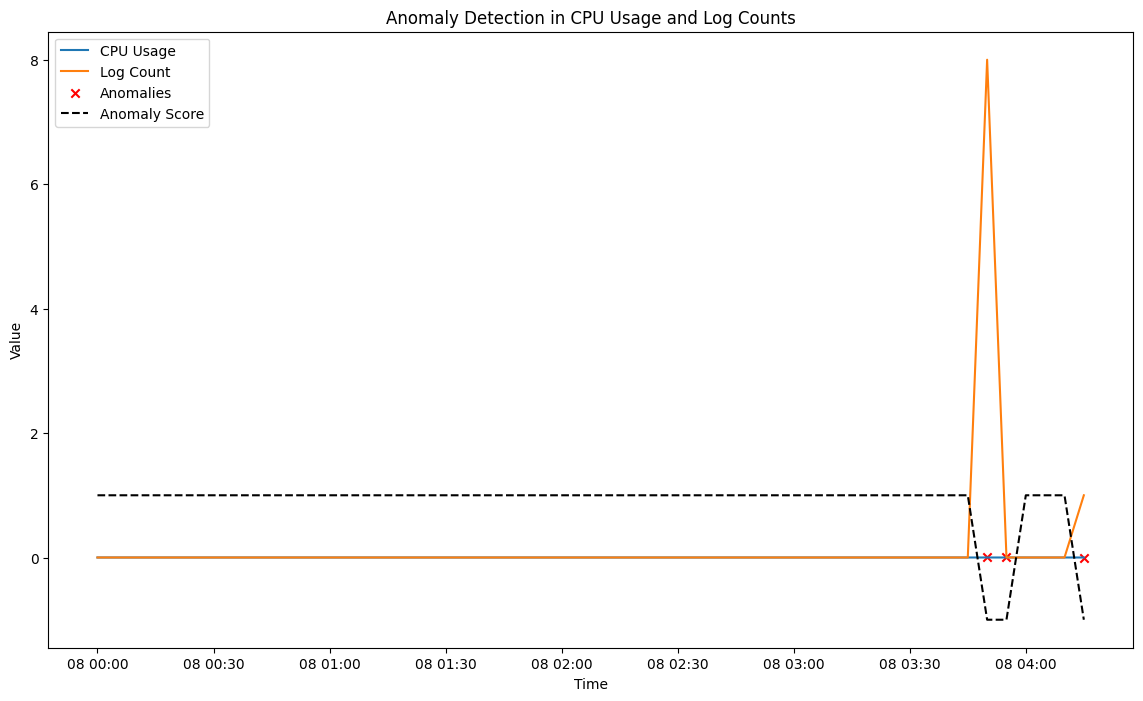

In [54]:
# Step 5: Visualizing Anomalies
import matplotlib.pyplot as plt
import seaborn as sns
# Print column names of the combined DataFrame to debug
print("Columns of combined_df:", combined_df.columns)

plt.figure(figsize=(14, 8))

# Plot CPU usage and log count
sns.lineplot(data=combined_df['cpuusage'], label='CPU Usage')
sns.lineplot(data=combined_df['log_count'], label='Log Count')

# Identify and plot anomalies based on anomaly score
anomalies = combined_df[combined_df['anomaly_score'] == -1]
plt.scatter(anomalies.index, anomalies['cpuusage'], color='red', label='Anomalies', marker='x')

# Highlight anomaly scores on the plot
sns.lineplot(data=combined_df['anomaly_score'], label='Anomaly Score', linestyle='--', color='black')

# Title and labels
plt.title('Anomaly Detection in CPU Usage and Log Counts')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()